**1 Neural Network Library**

1.1 Creating the Layer Class

In [5]:
import numpy as np
from numpy import exp
from scipy import signal
from keras.datasets import mnist
from keras.utils import np_utils
# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    # computes the output Y of a layer for a given input X
    def f_prop(self, input):
        pass
    # computes dE/dX for a given dE/dY (and update parameters if any)
    def b_prop(self, op_error, rate_of_learning):
        pass

1.2 LinearLayer

In [6]:
# inherit from base class Layer
class LinearLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        # print(self.weights)


    # returns output for a given input
    def f_prop(self, input_data):
        self.input = input_data
        return np.dot(self.weights, self.input)


    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def b_prop(self, op_error, rate_of_learning):
      wgt_error = np.dot(op_error, self.input.T)
      ip_error = np.dot(self.weights.T, op_error)
      # print("ip error================:",ip_error)
      self.weights -= rate_of_learning * wgt_error
      return ip_error




1.3 Sigmoid Function

In [7]:
class SigmoidFunc(Layer):
    def sigmoid(x):                                       
        return 1 / (1 + np.exp(-x))
    #https://stackoverflow.com/questions/49977063/role-derivative-of-sigmoid-function-in-neural-networks
    def sigmoid_dv(x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def f_prop(self, input_data):
      self.input = input_data
      self.output = self.sigmoid(self.input)
      return self.output

    def b_prop(self, op_error, rate_of_learning):
        return sigmoid_dv(self.input) * op_error

1.4 Hyperbolic Tangent Function

In [8]:
#activation function and its derivative
class TangentFunc(Layer):
    def tangent(self,x):
        return np.tanh(x)

    def tangent_dv(self,x):
        return 1-np.tanh(x)**2

    def f_prop(self,input_data):
      self.input = input_data
      self.output = self.tangent(self.input)
      return self.output

    def b_prop(self,op_error,rate_of_learning):
      # print("op error:",op_error)
      output = self.tangent_dv(self.input) * op_error
      # print("caluicated gradient:",output)
      return output


1.5 Softmax

In [9]:
class Softmax(Layer):

    def __init__(self):
      pass

    def f_prop(self, input):
        newt = np.exp(input)
        self.output = newt / np.sum(newt)
        return self.output
    
    def b_prop(self, op_error, rate_of_learning):
        n = np.size(self.output)
        return np.dot((np.identity(n) - self.output.T) * self.output, op_error)
       


 

Flatten Layer for Activation Function

In [10]:
# inherit from base class Layer
class FLayer(Layer):
    # returns the flattened input
    def f_prop(self, ip_data):
        self.input = ip_data
        self.output = ip_data.flatten().reshape((1,-1))
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def b_prop(self, output_error, learning_rate):
        return output_error.reshape(self.input.shape)

1.6 Negative Log Likelihood

In [11]:
# loss function and derivative of loss function
def MeanSqError(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def MeanSqError_Dv(y_true, y_pred):
    return 2 * (y_pred - y_true) / np.size(y_true)
    


1.7 The Sequential Class

In [19]:
class Sequential:
    def __init__(self,network):
        self.network = network
        self.loss = None
        self.loss_prime = None

    def use(self,loss,loss_prime):
      self.loss=loss
      self.loss_prime = loss_prime

            
    def predict(self,network, input):
      output = input
      for layer in network:
          output = layer.f_prop(output)
      return output

    def train(self,x_train, y_train, epochs = 1000, learning_rate = 0.01, verbose = True):
        all_errors = []

        for e in range(epochs):
            error = 0
            for x, y in zip(x_train, y_train):
                # forward
                output = self.predict(network, x)

                # error
                error += self.loss(y, output)
                # backward
                grad = self.loss_prime(y, output)
                # print("grad:",grad)
                for layer in reversed(network):
                    # print(layer)
                    grad = layer.b_prop(grad, learning_rate)
                    # print("Grad from return:",grad)

            error /= len(x_train)
            all_errors.append(error)
            if verbose:
                print(f"{e + 1}/{epochs}, error={error}")
        return all_errors

**2 Testing your library**

In [15]:
from numpy.core.fromnumeric import swapaxes
X = np.reshape([[0, 0], [0, 1], [1, 0], [1, 1]], (4, 2, 1))
Y = np.reshape([[0], [1], [1], [0]], (4, 1, 1))

network = [
    LinearLayer(2, 3),
    TangentFunc(),
    LinearLayer(3, 1),
    TangentFunc()
]

net = Sequential(network)

# train
net.use(MeanSqError,MeanSqError_Dv)
net.train(X,Y)

# decision boundary plot
points = []
for x in np.linspace(0, 1, 20):
    for y in np.linspace(0, 1, 20):
        z = net.predict(network, [[x], [y]])
        points.append([x, y, z[0,0]])
print(points)

1/1000, error=2.2116412480607472
[[0.0, 0.0, 0.0], [0.0, 0.05263157894736842, -0.1322577645857848], [0.0, 0.10526315789473684, -0.2596225010760066], [0.0, 0.15789473684210525, -0.3779224338553495], [0.0, 0.21052631578947367, -0.48421180327860414], [0.0, 0.2631578947368421, -0.5769476389137173], [0.0, 0.3157894736842105, -0.6558645534805565], [0.0, 0.3684210526315789, -0.7216642673432562], [0.0, 0.42105263157894735, -0.7756519042265662], [0.0, 0.47368421052631576, -0.8194138373839476], [0.0, 0.5263157894736842, -0.8545805902363187], [0.0, 0.5789473684210527, -0.8826787838904034], [0.0, 0.631578947368421, -0.9050555194816824], [0.0, 0.6842105263157894, -0.9228528792380859], [0.0, 0.7368421052631579, -0.9370126308939025], [0.0, 0.7894736842105263, -0.9482964467956422], [0.0, 0.8421052631578947, -0.9573121179697993], [0.0, 0.894736842105263, -0.9645402562205045], [0.0, 0.9473684210526315, -0.9703586959978344], [0.0, 1.0, -0.97506347370832], [0.05263157894736842, 0.0, -0.1475855259962779], 

**3 Handwritten Digit Recognition**

1st Model

1/5, error=0.162905647267262
2/5, error=0.06129579937461498
3/5, error=0.05005411260124499
4/5, error=0.043892047097917455
5/5, error=0.03962892678633185
[(0, 0.162905647267262), (1, 0.06129579937461498), (2, 0.05005411260124499), (3, 0.043892047097917455), (4, 0.03962892678633185)]


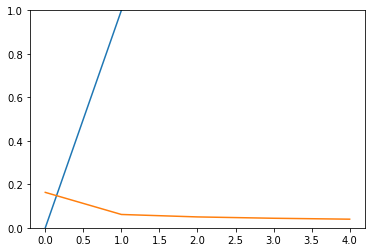

pred: 7 	true: 7
pred: 2 	true: 2
pred: 1 	true: 1
pred: 0 	true: 0
pred: 4 	true: 4
pred: 1 	true: 1
pred: 4 	true: 4
pred: 9 	true: 9
pred: 8 	true: 5
pred: 9 	true: 9
pred: 0 	true: 0
pred: 8 	true: 6
pred: 9 	true: 9
pred: 0 	true: 0
pred: 1 	true: 1
pred: 8 	true: 5
pred: 9 	true: 9
pred: 7 	true: 7
pred: 8 	true: 3
pred: 4 	true: 4
pred: 8 	true: 9
pred: 6 	true: 6
pred: 6 	true: 6
pred: 8 	true: 5
pred: 4 	true: 4
pred: 0 	true: 0
pred: 7 	true: 7
pred: 4 	true: 4
pred: 0 	true: 0
pred: 1 	true: 1
pred: 3 	true: 3
pred: 1 	true: 1
pred: 3 	true: 3
pred: 0 	true: 4
pred: 7 	true: 7
pred: 2 	true: 2
pred: 7 	true: 7
pred: 1 	true: 1
pred: 3 	true: 2
pred: 1 	true: 1
pred: 1 	true: 1
pred: 7 	true: 7
pred: 4 	true: 4
pred: 2 	true: 2
pred: 3 	true: 3
pred: 3 	true: 5
pred: 1 	true: 1
pred: 2 	true: 2
pred: 4 	true: 4
pred: 4 	true: 4
pred: 6 	true: 6
pred: 3 	true: 3
pred: 5 	true: 5
pred: 3 	true: 5
pred: 2 	true: 6
pred: 0 	true: 0
pred: 4 	true: 4
pred: 1 	true: 1
pred: 9 	true:

In [31]:
from keras.datasets import mnist
from keras.utils import np_utils
import matplotlib.pyplot as plt 
#load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 28*28,1)
x_train = x_train.astype('float32')
x_train /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = np_utils.to_categorical(y_train)
y_train = y_train.reshape(y_train.shape[0],10,1)


# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 28*28,1)
x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test)
y_test = y_test.reshape(y_test.shape[0],10,1)

network = [
    LinearLayer(28 * 28, 40),
    TangentFunc(),
    LinearLayer(40, 10),
    TangentFunc()
]

# train
net = Sequential(network)
net.use(MeanSqError,MeanSqError_Dv)
error = net.train( x_train, y_train, epochs=5, learning_rate=0.1)
err = []
for x,y in list(enumerate(error)):
  err.append((x,y))

print(err)
plt.ylim(ymin=0,ymax=1)
plt.plot(err)
plt.show()
# test
for x, y in zip(x_test[:100], y_test[:100]):
    output = net.predict(network, x)
    print('pred:', np.argmax(output), '\ttrue:', np.argmax(y))

2nd Model

1/50, error=0.16372611704323758
2/50, error=0.06400193600393575
3/50, error=0.05186730620812308
4/50, error=0.045489345506264406
5/50, error=0.041786684679950885
6/50, error=0.03920031392941341
7/50, error=0.03735519272185007
8/50, error=0.03594994780343378
9/50, error=0.03481934805007976
10/50, error=0.03384761663980352
11/50, error=0.03305612784246682
12/50, error=0.0323825321657158
13/50, error=0.031807418578847974
14/50, error=0.03127868285382681
15/50, error=0.030791575740941792
16/50, error=0.030329697621146512
17/50, error=0.029903966997673944
18/50, error=0.029492136080683826
19/50, error=0.02908177337952873
20/50, error=0.02867897834751019
21/50, error=0.02830627991460691
22/50, error=0.027977380621579544
23/50, error=0.02767276103890937
24/50, error=0.02738096080980241
25/50, error=0.02711046770010918
26/50, error=0.026776451005428664
27/50, error=0.026396415266892834
28/50, error=0.02611302216766517
29/50, error=0.025882558258104538
30/50, error=0.025676433914553407
31/50, e

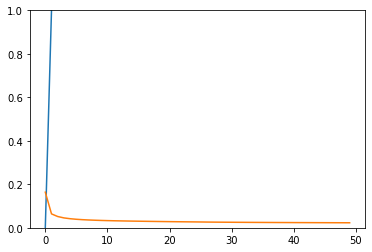

pred: 7 	true: 7
pred: 2 	true: 2
pred: 1 	true: 1
pred: 0 	true: 0
pred: 4 	true: 4
pred: 1 	true: 1
pred: 4 	true: 4
pred: 9 	true: 9
pred: 5 	true: 5
pred: 9 	true: 9
pred: 0 	true: 0
pred: 8 	true: 6
pred: 9 	true: 9
pred: 0 	true: 0
pred: 1 	true: 1
pred: 5 	true: 5
pred: 9 	true: 9
pred: 7 	true: 7
pred: 8 	true: 3
pred: 4 	true: 4
pred: 9 	true: 9
pred: 6 	true: 6
pred: 6 	true: 6
pred: 5 	true: 5
pred: 4 	true: 4
pred: 0 	true: 0
pred: 7 	true: 7
pred: 4 	true: 4
pred: 0 	true: 0
pred: 1 	true: 1
pred: 3 	true: 3
pred: 1 	true: 1
pred: 3 	true: 3
pred: 6 	true: 4
pred: 7 	true: 7
pred: 2 	true: 2
pred: 7 	true: 7
pred: 1 	true: 1
pred: 2 	true: 2
pred: 1 	true: 1
pred: 1 	true: 1
pred: 7 	true: 7
pred: 4 	true: 4
pred: 2 	true: 2
pred: 3 	true: 3
pred: 5 	true: 5
pred: 1 	true: 1
pred: 2 	true: 2
pred: 4 	true: 4
pred: 4 	true: 4
pred: 6 	true: 6
pred: 3 	true: 3
pred: 5 	true: 5
pred: 3 	true: 5
pred: 8 	true: 6
pred: 0 	true: 0
pred: 4 	true: 4
pred: 1 	true: 1
pred: 9 	true:

In [32]:
from keras.datasets import mnist
from keras.utils import np_utils
import matplotlib.pyplot as plt 
#load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 28*28,1)
x_train = x_train.astype('float32')
x_train /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = np_utils.to_categorical(y_train)
y_train = y_train.reshape(y_train.shape[0],10,1)


# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 28*28,1)
x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test)
y_test = y_test.reshape(y_test.shape[0],10,1)

network = [
    LinearLayer(28 * 28, 40),
    TangentFunc(),
    LinearLayer(40, 10),
    TangentFunc()
]

# train
net = Sequential(network)
net.use(MeanSqError,MeanSqError_Dv)
error = net.train( x_train, y_train, epochs=50, learning_rate=0.1)
err = []
for x,y in list(enumerate(error)):
  err.append((x,y))

print(err)
plt.ylim(ymin=0,ymax=1)
plt.plot(err)
plt.show()
# test
for x, y in zip(x_test[:100], y_test[:100]):
    output = net.predict(network, x)
    print('pred:', np.argmax(output), '\ttrue:', np.argmax(y))

3rd Model

1/100, error=0.7110302457851924
2/100, error=0.1312992357078108
3/100, error=0.07923017498327938
4/100, error=0.07201493488903467
5/100, error=0.06735554466222118
6/100, error=0.06386096867114743
7/100, error=0.06090706508312574
8/100, error=0.05817543636434913
9/100, error=0.055561102928872924
10/100, error=0.0531332621303221
11/100, error=0.05099276856282326
12/100, error=0.04908048728699118
13/100, error=0.04739726392303343
14/100, error=0.04591630633482337
15/100, error=0.04463238656425232
16/100, error=0.043558058844369876
17/100, error=0.042660309490361155
18/100, error=0.041882553225990216
19/100, error=0.0411744306409477
20/100, error=0.04053294937833357
21/100, error=0.03995663392769697
22/100, error=0.03942686636262456
23/100, error=0.038927167524538724
24/100, error=0.03845045353553715
25/100, error=0.03800176629948868
26/100, error=0.03757540358311118
27/100, error=0.03717585510584918
28/100, error=0.036799937229683645
29/100, error=0.03643366721412809
30/100, error=0.03608

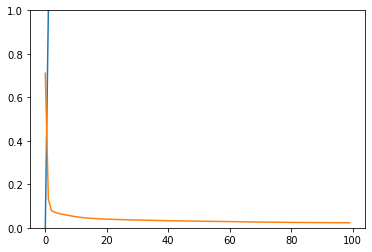

pred: 7 	true: 7
pred: 2 	true: 2
pred: 1 	true: 1
pred: 0 	true: 0
pred: 4 	true: 4
pred: 1 	true: 1
pred: 4 	true: 4
pred: 9 	true: 9
pred: 8 	true: 5
pred: 9 	true: 9
pred: 0 	true: 0
pred: 8 	true: 6
pred: 9 	true: 9
pred: 0 	true: 0
pred: 1 	true: 1
pred: 5 	true: 5
pred: 9 	true: 9
pred: 7 	true: 7
pred: 8 	true: 3
pred: 4 	true: 4
pred: 9 	true: 9
pred: 6 	true: 6
pred: 6 	true: 6
pred: 5 	true: 5
pred: 4 	true: 4
pred: 0 	true: 0
pred: 7 	true: 7
pred: 4 	true: 4
pred: 0 	true: 0
pred: 1 	true: 1
pred: 3 	true: 3
pred: 1 	true: 1
pred: 3 	true: 3
pred: 0 	true: 4
pred: 7 	true: 7
pred: 2 	true: 2
pred: 7 	true: 7
pred: 1 	true: 1
pred: 2 	true: 2
pred: 1 	true: 1
pred: 1 	true: 1
pred: 7 	true: 7
pred: 4 	true: 4
pred: 2 	true: 2
pred: 3 	true: 3
pred: 5 	true: 5
pred: 1 	true: 1
pred: 2 	true: 2
pred: 4 	true: 4
pred: 4 	true: 4
pred: 6 	true: 6
pred: 3 	true: 3
pred: 5 	true: 5
pred: 5 	true: 5
pred: 6 	true: 6
pred: 0 	true: 0
pred: 4 	true: 4
pred: 1 	true: 1
pred: 9 	true:

In [33]:
from keras.datasets import mnist
from keras.utils import np_utils
import matplotlib.pyplot as plt 
#load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 28*28,1)
x_train = x_train.astype('float32')
x_train /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = np_utils.to_categorical(y_train)
y_train = y_train.reshape(y_train.shape[0],10,1)


# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 28*28,1)
x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test)
y_test = y_test.reshape(y_test.shape[0],10,1)

network = [
    LinearLayer(28 * 28, 40),
    TangentFunc(),
    LinearLayer(40, 10),
    TangentFunc()
]

# train
net = Sequential(network)
net.use(MeanSqError,MeanSqError_Dv)
error = net.train( x_train, y_train, epochs=100, learning_rate=0.01)
err = []
for x,y in list(enumerate(error)):
  err.append((x,y))

print(err)
plt.ylim(ymin=0,ymax=1)
plt.plot(err)
plt.show()
# test
for x, y in zip(x_test[:100], y_test[:100]):
    output = net.predict(network, x)
    print('pred:', np.argmax(output), '\ttrue:', np.argmax(y))

**4. Playing with Hyperparameters**

Train on MNIST using a learning rate of 1 

1/5, error=0.8857895779819634
2/5, error=0.8874247541595962
3/5, error=0.8883581115770824
4/5, error=0.8833564749297143
5/5, error=0.8859529078901932
[(0, 0.8857895779819634), (1, 0.8874247541595962), (2, 0.8883581115770824), (3, 0.8833564749297143), (4, 0.8859529078901932)]


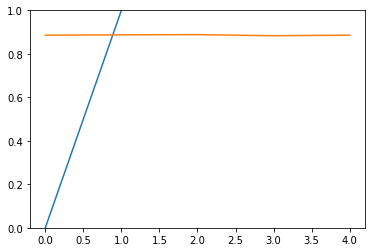

pred: 0 	true: 7
pred: 0 	true: 2
pred: 1 	true: 1
pred: 0 	true: 0
pred: 0 	true: 4
pred: 1 	true: 1
pred: 0 	true: 4
pred: 0 	true: 9
pred: 0 	true: 5
pred: 0 	true: 9
pred: 0 	true: 0
pred: 0 	true: 6
pred: 0 	true: 9
pred: 0 	true: 0
pred: 2 	true: 1
pred: 0 	true: 5
pred: 0 	true: 9
pred: 0 	true: 7
pred: 0 	true: 3
pred: 0 	true: 4
pred: 0 	true: 9
pred: 0 	true: 6
pred: 0 	true: 6
pred: 0 	true: 5
pred: 0 	true: 4
pred: 0 	true: 0
pred: 0 	true: 7
pred: 0 	true: 4
pred: 0 	true: 0
pred: 2 	true: 1
pred: 0 	true: 3
pred: 0 	true: 1
pred: 0 	true: 3
pred: 0 	true: 4
pred: 0 	true: 7
pred: 0 	true: 2
pred: 0 	true: 7
pred: 2 	true: 1
pred: 0 	true: 2
pred: 0 	true: 1
pred: 2 	true: 1
pred: 0 	true: 7
pred: 0 	true: 4
pred: 2 	true: 2
pred: 0 	true: 3
pred: 0 	true: 5
pred: 2 	true: 1
pred: 0 	true: 2
pred: 0 	true: 4
pred: 0 	true: 4
pred: 0 	true: 6
pred: 0 	true: 3
pred: 0 	true: 5
pred: 0 	true: 5
pred: 0 	true: 6
pred: 0 	true: 0
pred: 0 	true: 4
pred: 0 	true: 1
pred: 0 	true:

In [35]:
from keras.datasets import mnist
from keras.utils import np_utils
import matplotlib.pyplot as plt 
#load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 28*28,1)
x_train = x_train.astype('float32')
x_train /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = np_utils.to_categorical(y_train)
y_train = y_train.reshape(y_train.shape[0],10,1)


# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 28*28,1)
x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test)
y_test = y_test.reshape(y_test.shape[0],10,1)

network = [
    LinearLayer(28 * 28, 40),
    TangentFunc(),
    LinearLayer(40, 10),
    TangentFunc()
]

# train
net = Sequential(network)
net.use(MeanSqError,MeanSqError_Dv)
error = net.train( x_train, y_train, epochs=5, learning_rate=1)
err = []
for x,y in list(enumerate(error)):
  err.append((x,y))

print(err)
plt.ylim(ymin=0,ymax=1)
plt.plot(err)
plt.show()
# test
for x, y in zip(x_test[:100], y_test[:100]):
    output = net.predict(network, x)
    print('pred:', np.argmax(output), '\ttrue:', np.argmax(y))

Train on MNIST using a learning rate of
0.001.

1/5, error=0.922771197945112
2/5, error=0.8206451811571541
3/5, error=0.7874966246274193
4/5, error=0.7568830644361415
5/5, error=0.7234940732860969
[(0, 0.922771197945112), (1, 0.8206451811571541), (2, 0.7874966246274193), (3, 0.7568830644361415), (4, 0.7234940732860969)]


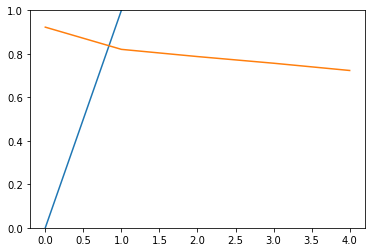

pred: 6 	true: 7
pred: 2 	true: 2
pred: 9 	true: 1
pred: 6 	true: 0
pred: 4 	true: 4
pred: 5 	true: 1
pred: 6 	true: 4
pred: 3 	true: 9
pred: 9 	true: 5
pred: 9 	true: 9
pred: 0 	true: 0
pred: 4 	true: 6
pred: 6 	true: 9
pred: 0 	true: 0
pred: 5 	true: 1
pred: 5 	true: 5
pred: 9 	true: 9
pred: 7 	true: 7
pred: 3 	true: 3
pred: 9 	true: 4
pred: 4 	true: 9
pred: 7 	true: 6
pred: 4 	true: 6
pred: 6 	true: 5
pred: 6 	true: 4
pred: 5 	true: 0
pred: 3 	true: 7
pred: 2 	true: 4
pred: 5 	true: 0
pred: 1 	true: 1
pred: 7 	true: 3
pred: 1 	true: 1
pred: 3 	true: 3
pred: 0 	true: 4
pred: 6 	true: 7
pred: 6 	true: 2
pred: 9 	true: 7
pred: 1 	true: 1
pred: 0 	true: 2
pred: 5 	true: 1
pred: 5 	true: 1
pred: 9 	true: 7
pred: 9 	true: 4
pred: 9 	true: 2
pred: 3 	true: 3
pred: 3 	true: 5
pred: 9 	true: 1
pred: 2 	true: 2
pred: 3 	true: 4
pred: 2 	true: 4
pred: 3 	true: 6
pred: 2 	true: 3
pred: 9 	true: 5
pred: 8 	true: 5
pred: 9 	true: 6
pred: 2 	true: 0
pred: 3 	true: 4
pred: 9 	true: 1
pred: 7 	true:

In [36]:
from keras.datasets import mnist
from keras.utils import np_utils
import matplotlib.pyplot as plt 
#load MNIST from server
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# training data : 60000 samples
# reshape and normalize input data
x_train = x_train.reshape(x_train.shape[0], 28*28,1)
x_train = x_train.astype('float32')
x_train /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train = np_utils.to_categorical(y_train)
y_train = y_train.reshape(y_train.shape[0],10,1)


# same for test data : 10000 samples
x_test = x_test.reshape(x_test.shape[0], 28*28,1)
x_test = x_test.astype('float32')
x_test /= 255
y_test = np_utils.to_categorical(y_test)
y_test = y_test.reshape(y_test.shape[0],10,1)

network = [
    LinearLayer(28 * 28, 40),
    TangentFunc(),
    LinearLayer(40, 10),
    TangentFunc()
]

# train
net = Sequential(network)
net.use(MeanSqError,MeanSqError_Dv)
error = net.train( x_train, y_train, epochs=5, learning_rate=0.001)
err = []
for x,y in list(enumerate(error)):
  err.append((x,y))

print(err)
plt.ylim(ymin=0,ymax=1)
plt.plot(err)
plt.show()
# test
for x, y in zip(x_test[:100], y_test[:100]):
    output = net.predict(network, x)
    print('pred:', np.argmax(output), '\ttrue:', np.argmax(y))